#0. Environment Setting

In [ ]:
import pandas as pd
import numpy as np
import chardet
import glob
import os
from scipy import stats

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.patches as patches


#2. Index construction & processing

###2.0 Correlation Analysis

In [ ]:
md_data = pd.read_csv("/content/model data.csv")
md_data

,Name,Date,DAU,Revenue
0,Honor of Kings,2015-10-25,5,0.16
1,Honor of Kings,2015-10-26,91703,25110.71
2,Honor of Kings,2015-10-26,91703,1940.52
3,Honor of Kings,2015-10-26,2391,25110.71
4,Honor of Kings,2015-10-26,2391,1940.52
...,...,...,...,...
112352,LifeAfter,2025-07-13,7086,51.55
112353,LifeAfter,2025-07-13,2605,21353.64
112354,LifeAfter,2025-07-13,2605,2998.57
112355,LifeAfter,2025-07-13,2605,41.96



DAU & REVENUE CORRELATION ANALYSIS REPORT

- Pearson Correlation: 0.4101 (p-value: 0.0000)
  • Interpretation: Moderate positive correlation
                   
- Spearman Rank Correlation: 0.4059 (p-value: 0.0000)
  • Interpretation: Moderate monotonic relationship




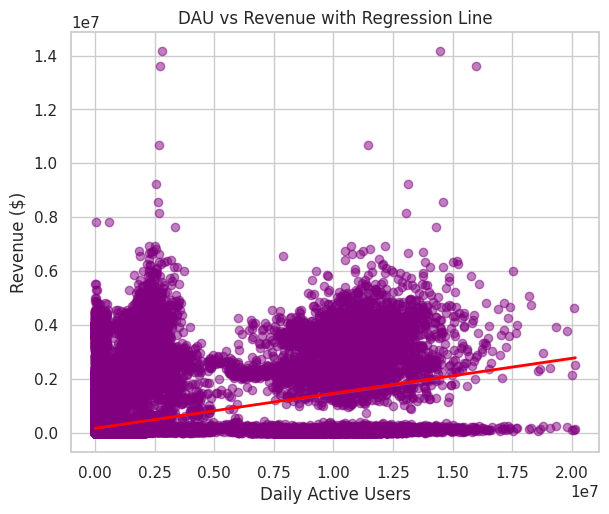

In [ ]:
# Calculate statistical measures
pearson_corr, pearson_p = stats.pearsonr(md_data['DAU'], md_data['Revenue'])
spearman_corr, spearman_p = stats.spearmanr(md_data['DAU'], md_data['Revenue'])

# 3. Visualization
plt.figure(figsize=(15, 12))

# Scatter Plot with Regression Line
plt.subplot(2, 2, 3)
sns.regplot(x='DAU', y='Revenue', data=md_data,
            scatter_kws={'alpha':0.5, 'color':'purple'},
            line_kws={'color':'red', 'linewidth':2})
plt.title('DAU vs Revenue with Regression Line', fontsize=12)
plt.xlabel('Daily Active Users')
plt.ylabel('Revenue ($)')


# Generate Report
report = f"""
DAU & REVENUE CORRELATION ANALYSIS REPORT

- Pearson Correlation: {pearson_corr:.4f} (p-value: {pearson_p:.4f})
  • Interpretation: {'Strong positive correlation' if pearson_corr > 0.7 else
                   'Moderate positive correlation' if pearson_corr > 0.3 else
                   'Weak positive correlation' if pearson_corr > 0 else
                   'No correlation' if pearson_corr == 0 else
                   'Negative correlation'}

- Spearman Rank Correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4f})
  • Interpretation: {'Strong monotonic relationship' if spearman_corr > 0.7 else
                    'Moderate monotonic relationship' if spearman_corr > 0.3 else
                    'Weak monotonic relationship' if spearman_corr > 0 else
                    'No monotonic relationship' if spearman_corr == 0 else
                    'Negative monotonic relationship'}

"""

print(report)



###2.1 Active Value Indicator by DAU & Revenue (AVI0)

In [ ]:
md_data = pd.read_csv("/content/model data.csv")

In [ ]:
#AVI caculation
md_data['AVI'] = np.log1p(md_data['DAU'] * md_data['Revenue'])

In [ ]:
# Eliminate noise: Construct a smooth AVI indicator (3-period moving average)
md_data['AVI_smooth'] = md_data.groupby('Name')['AVI'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# sort by Name & Date
md_data = md_data.sort_values(by=['Name', 'Date']).reset_index(drop=True)

# save
md_data.to_csv("ModelData_With_AVI.csv", index=False)

# see data
md_data.head()

,Name,Date,DAU,Revenue,AVI,AVI_smooth
0,Dawn of kingdoms,2022-03-29,174110,516004.42,25.221313,25.221313
1,Dawn of kingdoms,2022-03-29,174110,41704.03,22.705796,23.963554
2,Dawn of kingdoms,2022-03-29,7923,516004.42,22.131396,23.352835
3,Dawn of kingdoms,2022-03-29,7923,41704.03,19.615878,21.484357
4,Dawn of kingdoms,2022-03-30,210370,605651.14,25.570683,22.439319


####Visualization

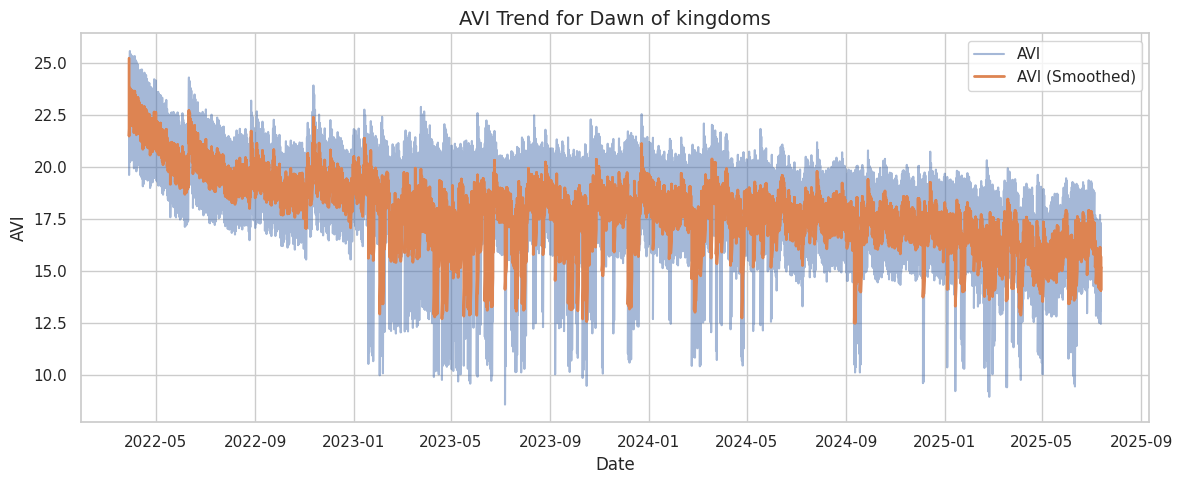

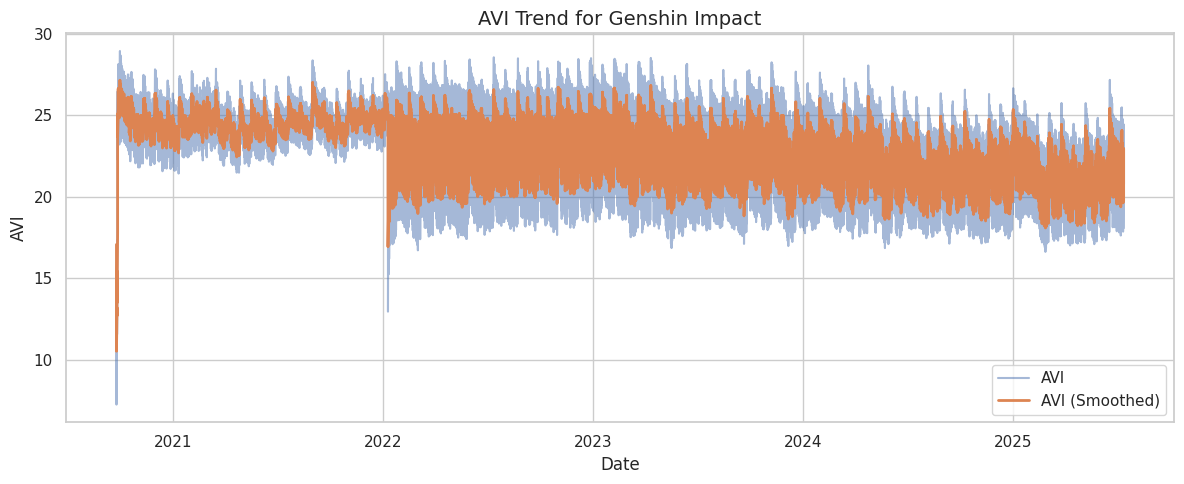

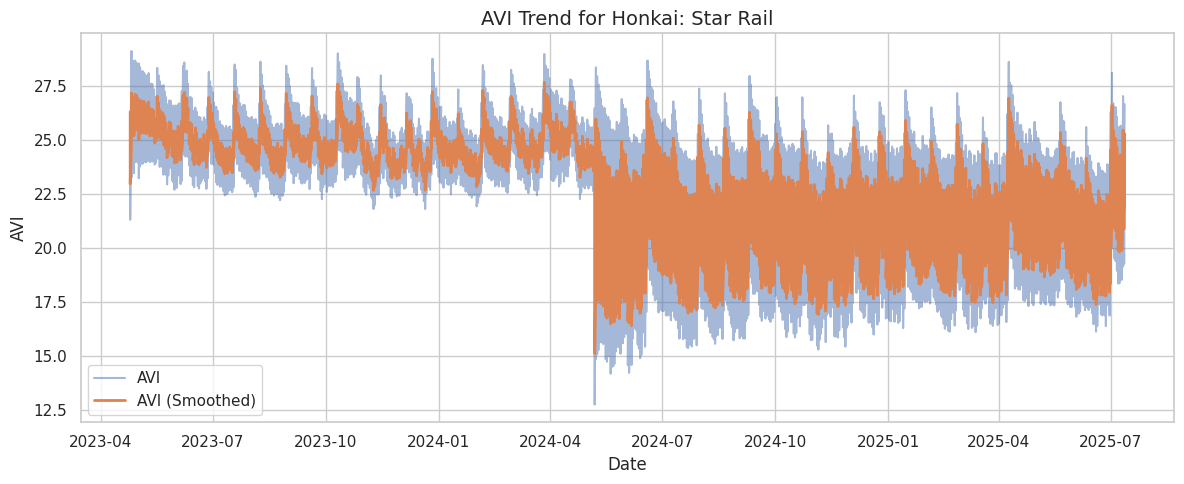

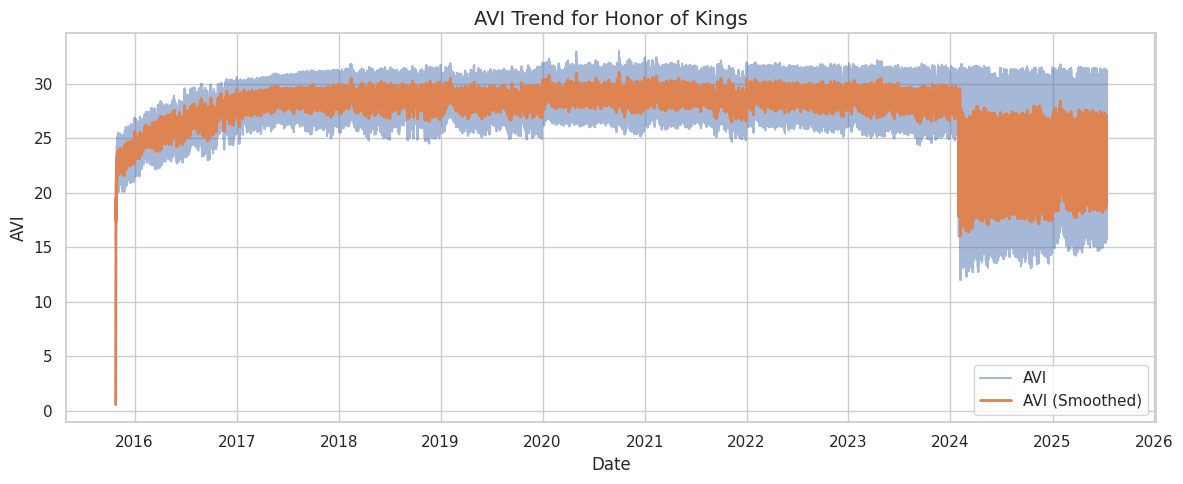

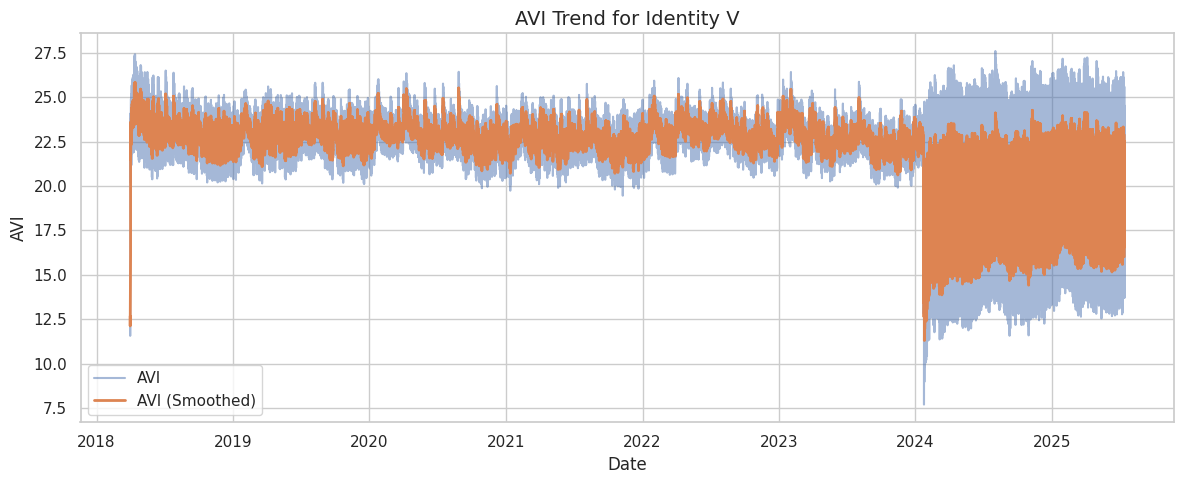

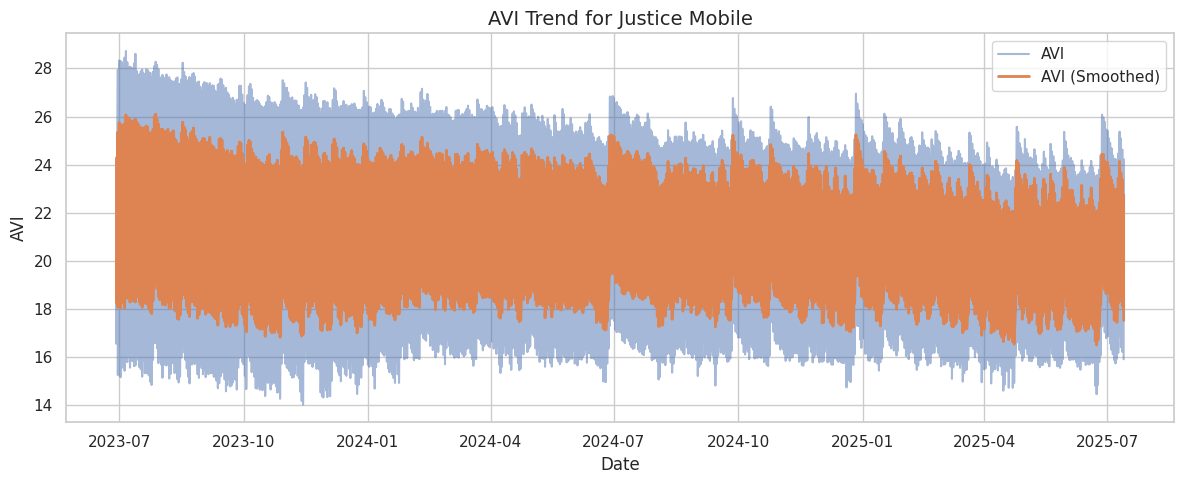

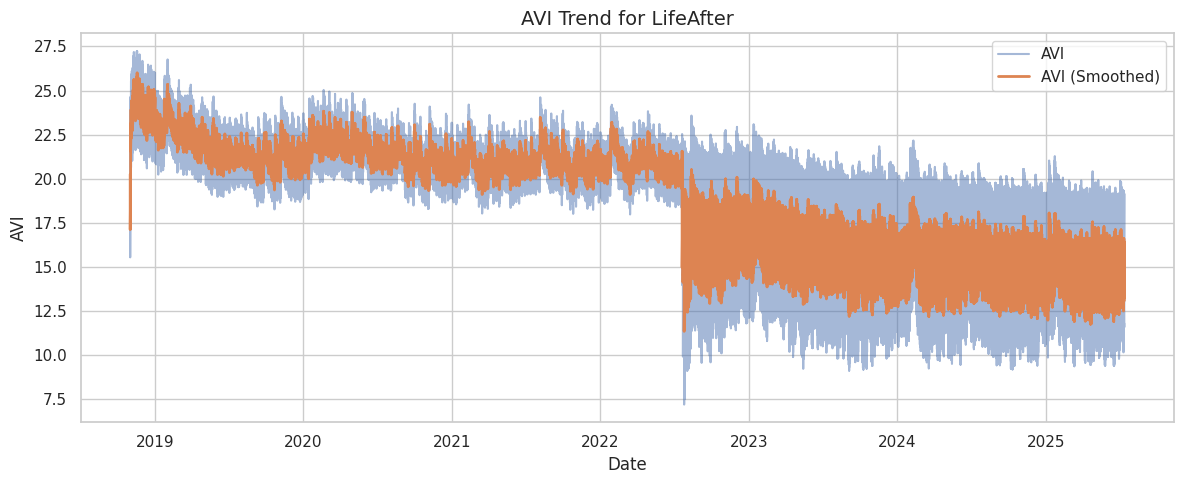

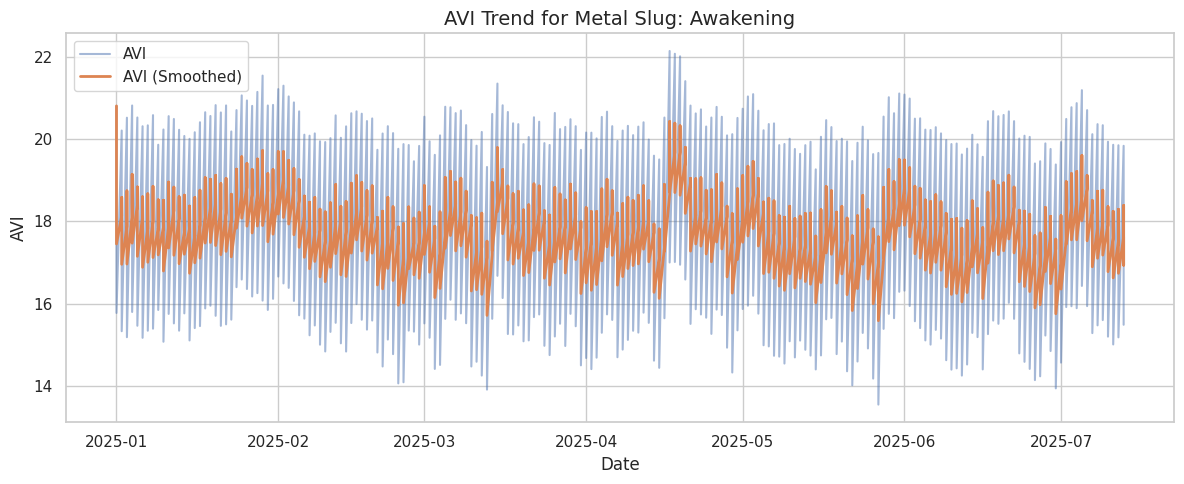

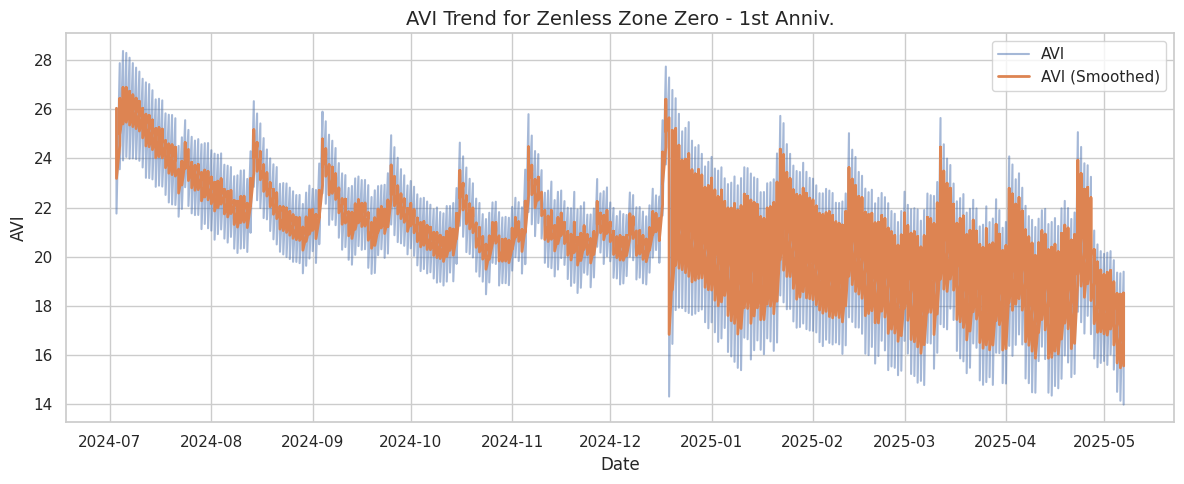

In [ ]:
#Visualization
# style
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# access data
games = md_data['Name'].unique()

# Draw for every game
for game in games:
    subset = md_data[md_data['Name'] == game]

    plt.figure(figsize=(12, 5))
    plt.plot(subset['Date'], subset['AVI'], label='AVI', alpha=0.5)
    plt.plot(subset['Date'], subset['AVI_smooth'], label='AVI (Smoothed)', linewidth=2)

    plt.title(f'AVI Trend for {game}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('AVI')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

###2.2 Weekly Aggregation (AVI0)

In [ ]:
md_data['Date'] = pd.to_datetime(md_data['Date'])
md_data = md_data[(md_data['DAU'] > 0) & (md_data['Revenue'] > 0)]

In [ ]:
md_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112357 entries, 0 to 112356
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Name        112357 non-null  object        
 1   Date        112357 non-null  datetime64[ns]
 2   DAU         112357 non-null  int64         
 3   Revenue     112357 non-null  float64       
 4   AVI         112357 non-null  float64       
 5   AVI_smooth  112357 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 5.1+ MB


In [ ]:
# set week
md_data['Week'] = md_data['Date'] - pd.to_timedelta(md_data['Date'].dt.dayofweek, unit='D')

# aggregation by week
weekly_md = md_data.groupby(['Name', 'Week']).agg({
    'DAU': 'mean',          # weekly mean DAU
    'Revenue': 'sum'        # week revenue
}).reset_index()

# caculate Weekly Active Value (WAVI)
weekly_md['WAVI'] = np.log1p(weekly_md['DAU'] * weekly_md['Revenue'])

# smooth moving average (3-week window)
weekly_md['WAVI_smooth'] = weekly_md.groupby('Name')['WAVI'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

#see
weekly_md.head()



,Name,Week,DAU,Revenue,WAVI,WAVI_smooth
0,Dawn of kingdoms,2022-03-28,97281.916667,7393367.08,27.301462,27.301462
1,Dawn of kingdoms,2022-04-04,71847.714286,8464934.44,27.133747,27.217605
2,Dawn of kingdoms,2022-04-11,56306.142857,6696899.02,26.655714,27.030308
3,Dawn of kingdoms,2022-04-18,49249.642857,5084670.74,26.246398,26.678620
4,Dawn of kingdoms,2022-04-25,48414.714286,4219808.02,26.042859,26.314991


In [ ]:
# Save
weekly_md.to_csv("Weekly_AVI_Data.csv", index=False)


####Visualization

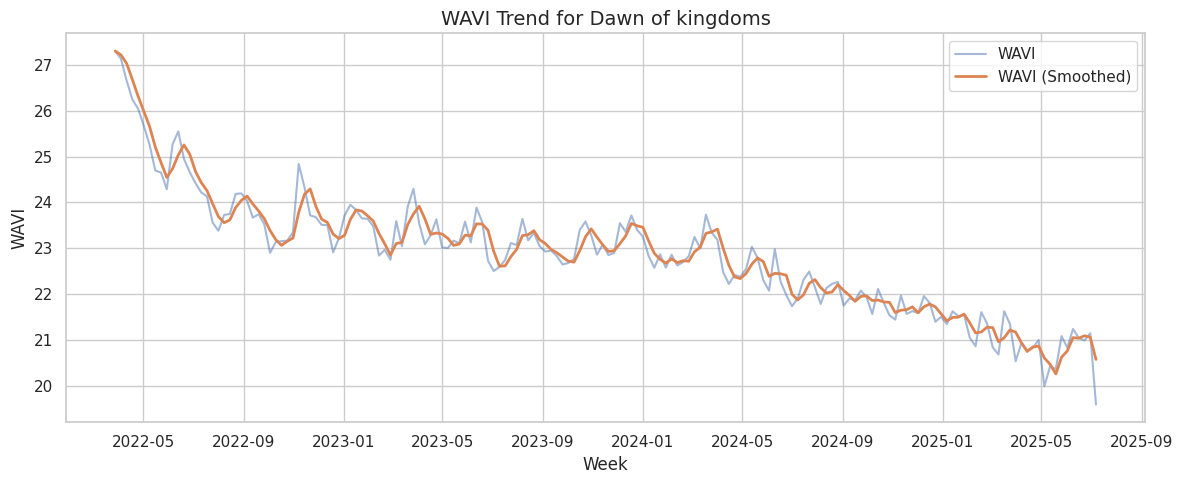

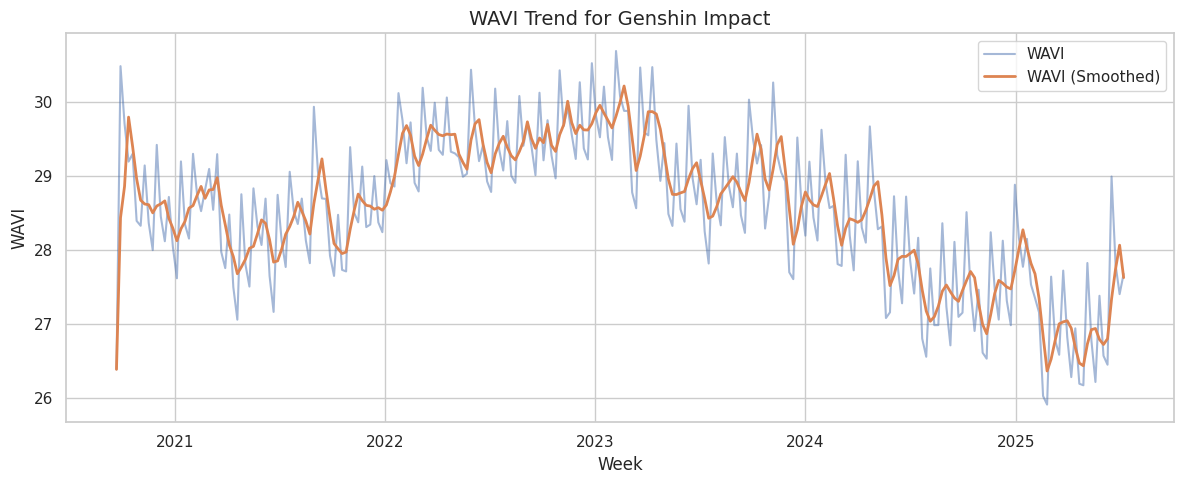

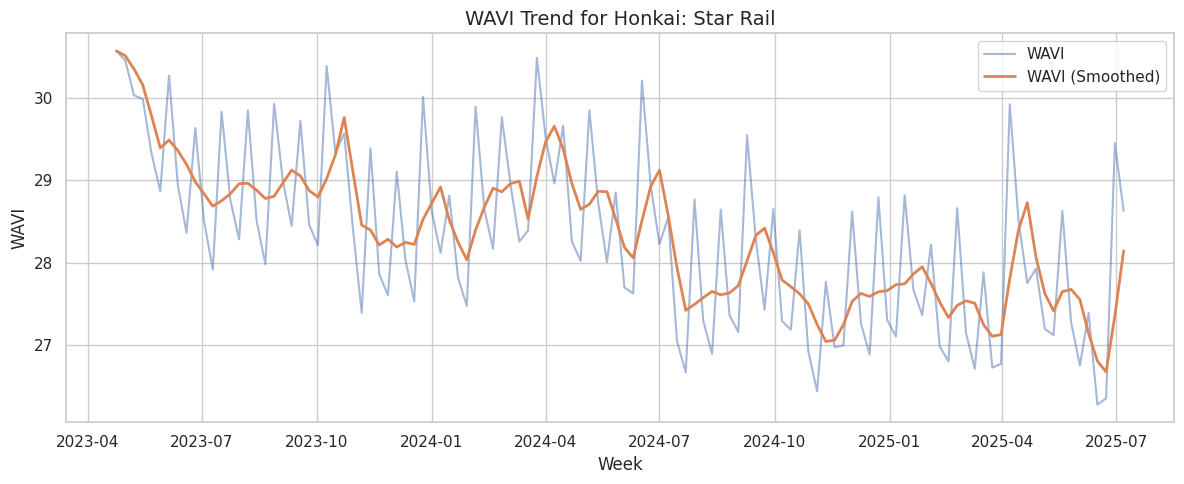

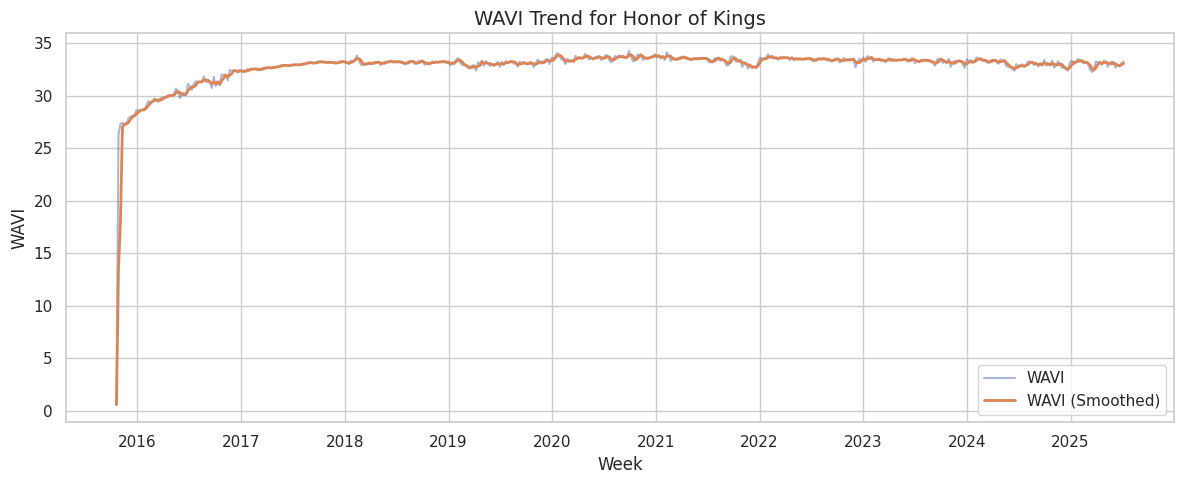

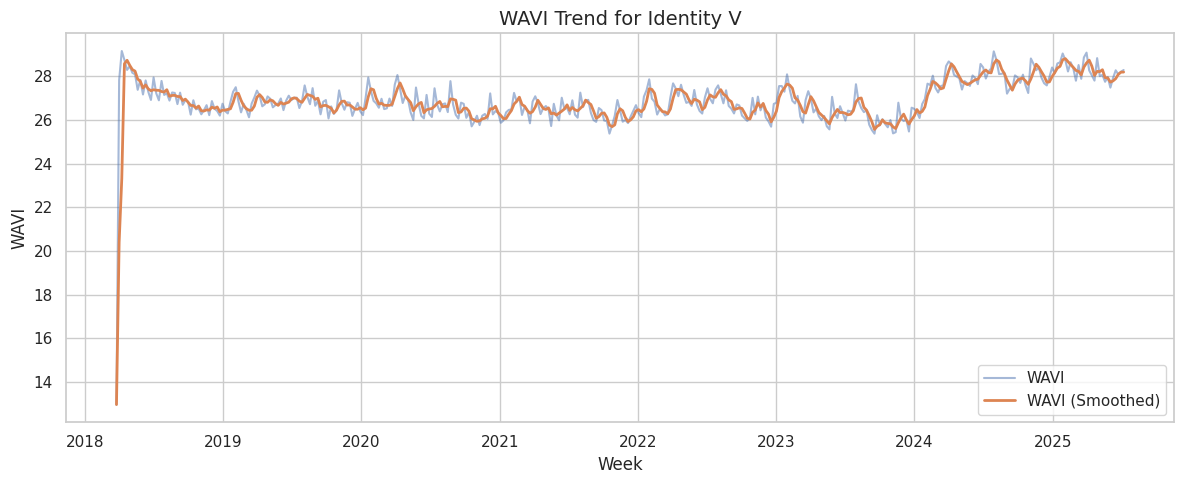

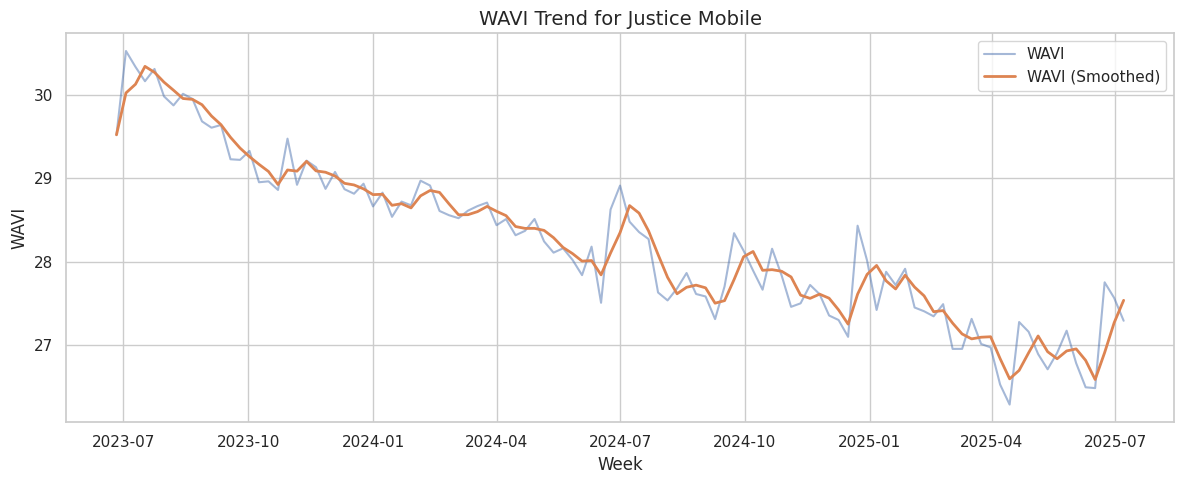

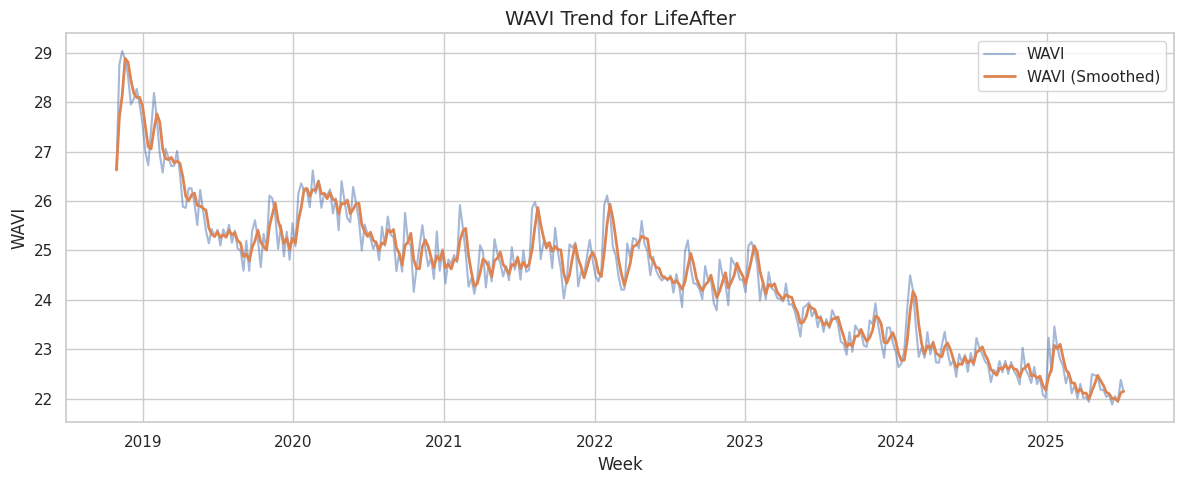

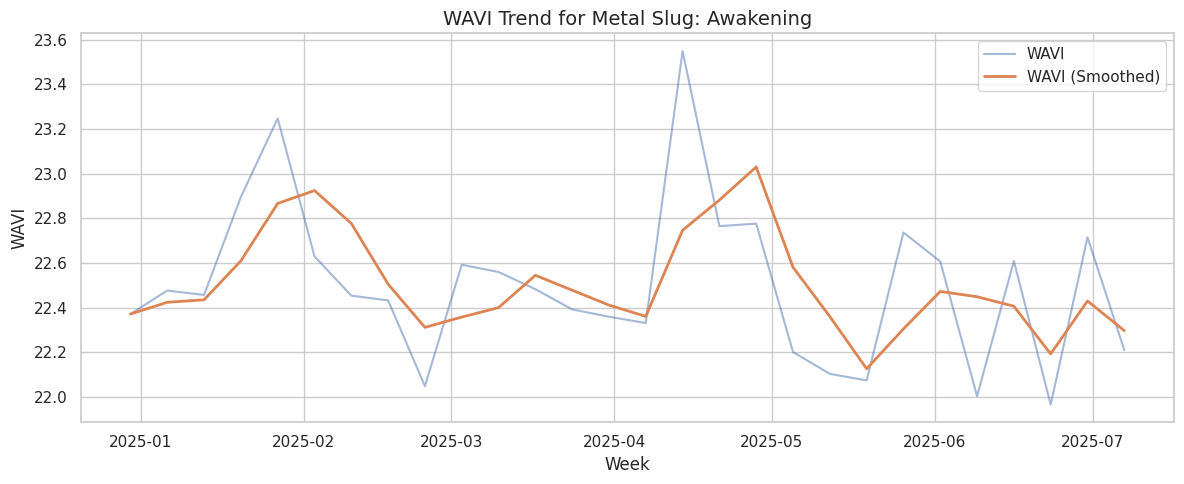

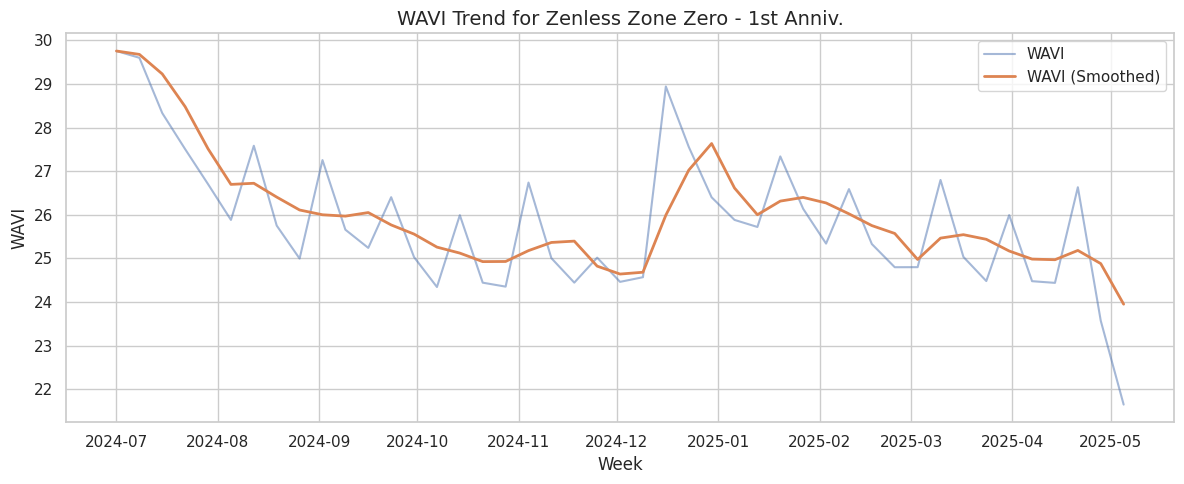

In [ ]:
#Visualization
# style
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# access data
games = weekly_md['Name'].unique()

# Draw for every game
for game in games:
    subset = weekly_md[weekly_md['Name'] == game]

    plt.figure(figsize=(12, 5))
    plt.plot(subset['Week'], subset['WAVI'], label='WAVI', alpha=0.5)
    plt.plot(subset['Week'], subset['WAVI_smooth'], label='WAVI (Smoothed)', linewidth=2)

    plt.title(f'WAVI Trend for {game}', fontsize=14)
    plt.xlabel('Week')
    plt.ylabel('WAVI')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

###2.3(*) Reformulation: Correct odds & weekly Aggregation & Smooth with Moving Average (optional)

In [ ]:
md_data

,Name,Date,DAU,Revenue
0,Honor of Kings,2015-10-25,5,0.16
1,Honor of Kings,2015-10-26,91703,25110.71
2,Honor of Kings,2015-10-26,91703,1940.52
3,Honor of Kings,2015-10-26,2391,25110.71
4,Honor of Kings,2015-10-26,2391,1940.52
...,...,...,...,...
112352,LifeAfter,2025-07-13,7086,51.55
112353,LifeAfter,2025-07-13,2605,21353.64
112354,LifeAfter,2025-07-13,2605,2998.57
112355,LifeAfter,2025-07-13,2605,41.96


In [ ]:
md_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112357 entries, 0 to 112356
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Name     112357 non-null  object 
 1   Date     112357 non-null  object 
 2   DAU      112357 non-null  int64  
 3   Revenue  112357 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.4+ MB


In [ ]:
# Define a very small value to avoid log(0)
epsilon = 1e-5

# Set week (truncate to the Monday of each week)
md_data['Week'] = md_data['Date'] - pd.to_timedelta(md_data['Date'].dt.dayofweek, unit='D')

# Weekly aggregation: average DAU and total Revenue
weekly_md_1 = md_data.groupby(['Name', 'Week']).agg({
    'DAU': 'mean',           # Weekly average DAU
    'Revenue': 'sum'         # Weekly total revenue
}).reset_index()

# Calculate Active Value Index 1 (AVI1) with epsilon adjustment
weekly_md_1['AVI1'] = np.log1p(
    weekly_md_1['DAU'].replace(0, epsilon) * weekly_md_1['Revenue'].replace(0, epsilon)
)

# Smooth AVI1 using 3-week moving average
weekly_md_1['AVI1_smooth'] = weekly_md_1.groupby('Name')['AVI1'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)


In [ ]:
weekly_md_1

,Name,Week,DAU,Revenue,AVI1,AVI1_smooth
0,Dawn of kingdoms,2022-03-28,97281.916667,7393367.08,27.301462,27.301462
1,Dawn of kingdoms,2022-04-04,71847.714286,8464934.44,27.133747,27.217605
2,Dawn of kingdoms,2022-04-11,56306.142857,6696899.02,26.655714,27.030308
3,Dawn of kingdoms,2022-04-18,49249.642857,5084670.74,26.246398,26.678620
4,Dawn of kingdoms,2022-04-25,48414.714286,4219808.02,26.042859,26.314991
...,...,...,...,...,...,...
1953,Zenless Zone Zero - 1st Anniv.,2025-04-07,50780.214286,841517.36,24.478224,24.984623
1954,Zenless Zone Zero - 1st Anniv.,2025-04-14,59343.678571,692731.32,24.439498,24.970653
1955,Zenless Zone Zero - 1st Anniv.,2025-04-21,69264.642857,5321682.40,26.632990,25.183571
1956,Zenless Zone Zero - 1st Anniv.,2025-04-28,15465.500000,1115576.08,23.571249,24.881246


In [ ]:
# Save
weekly_md_1.to_csv("Weekly_AVI1_Data.csv", index=False)

####Visualization

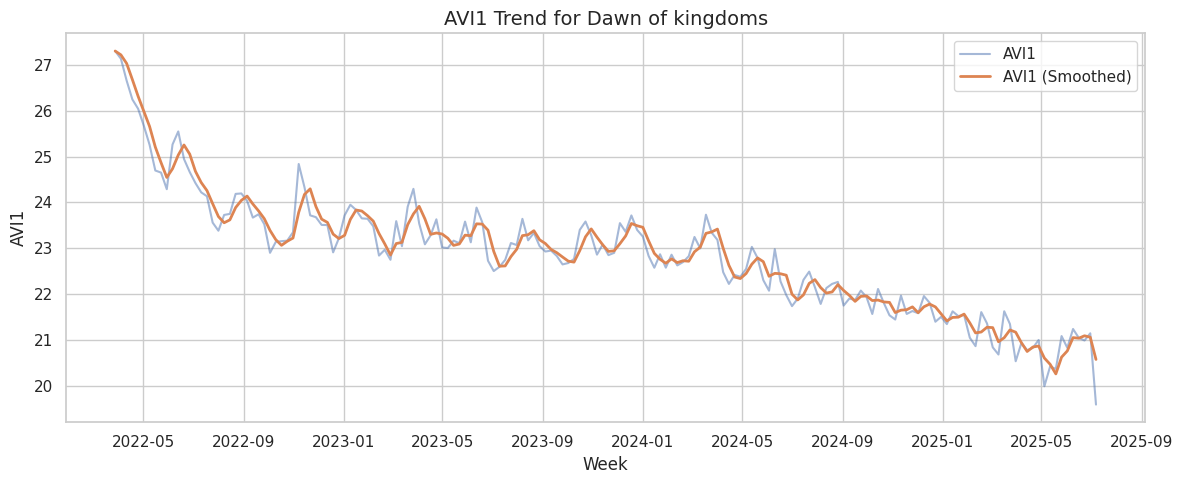

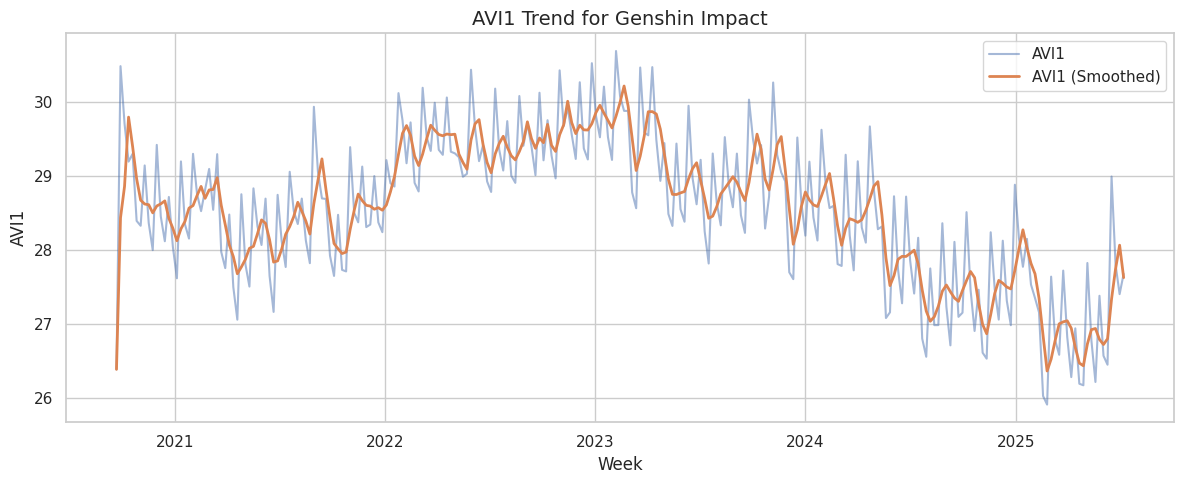

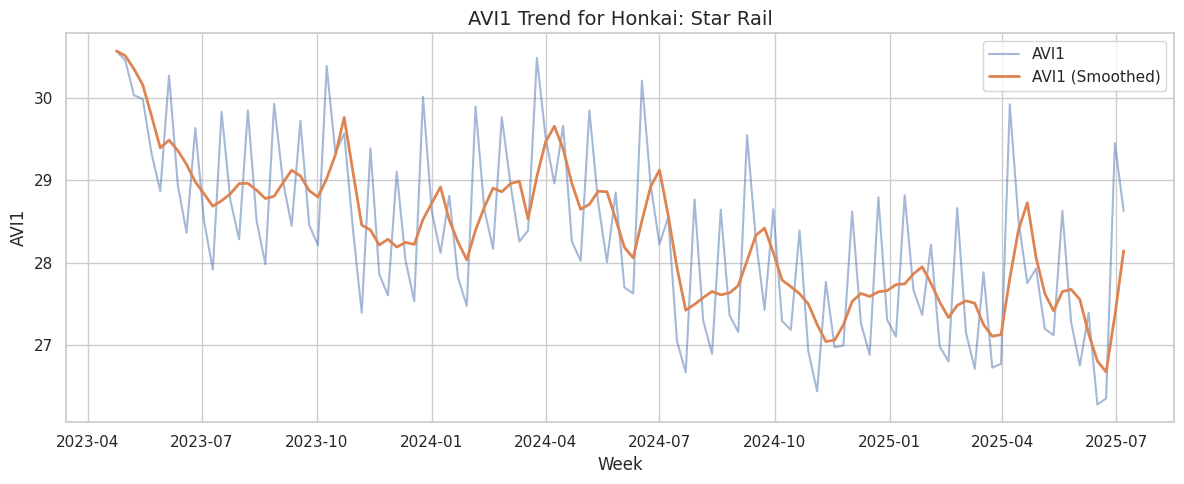

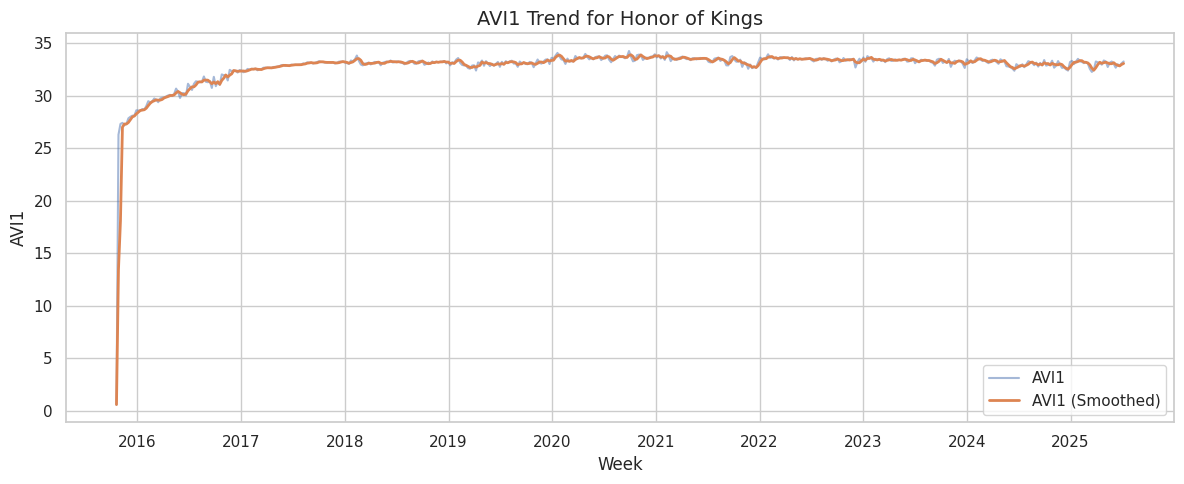

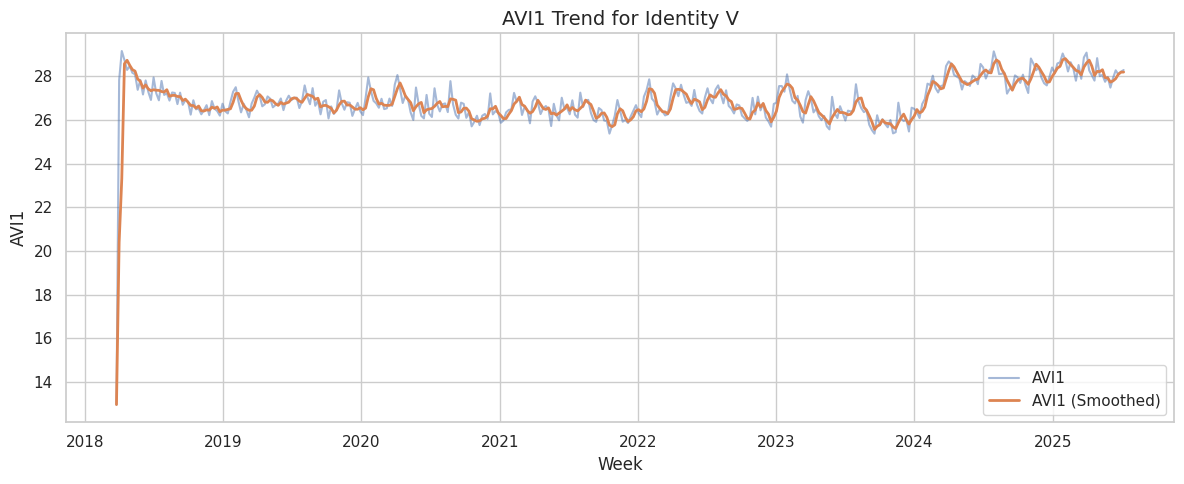

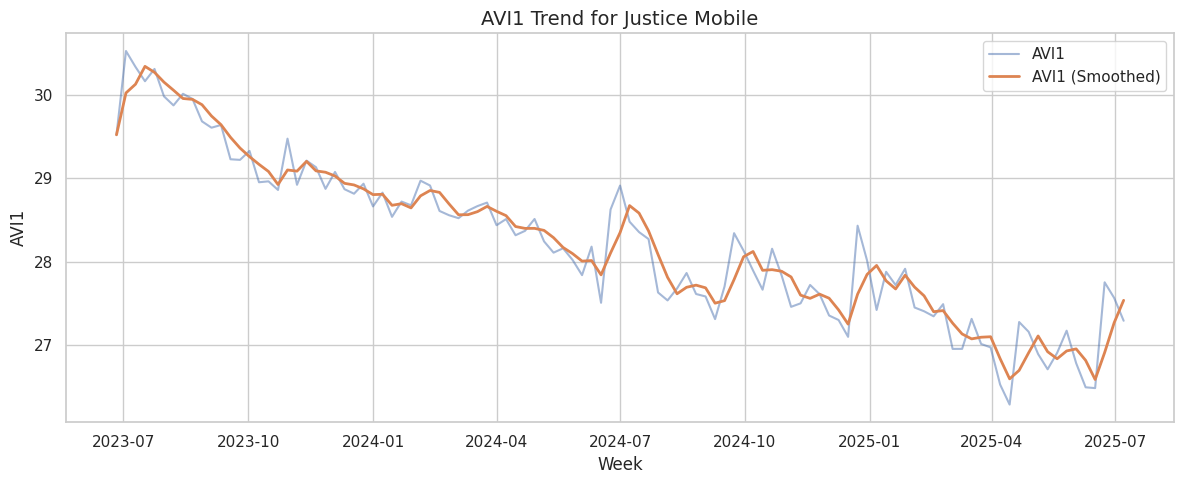

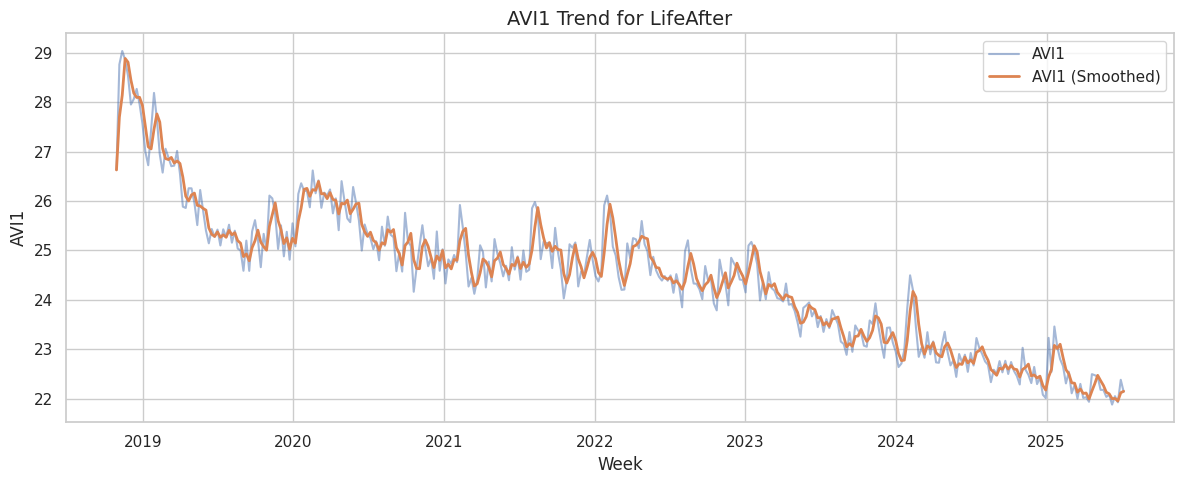

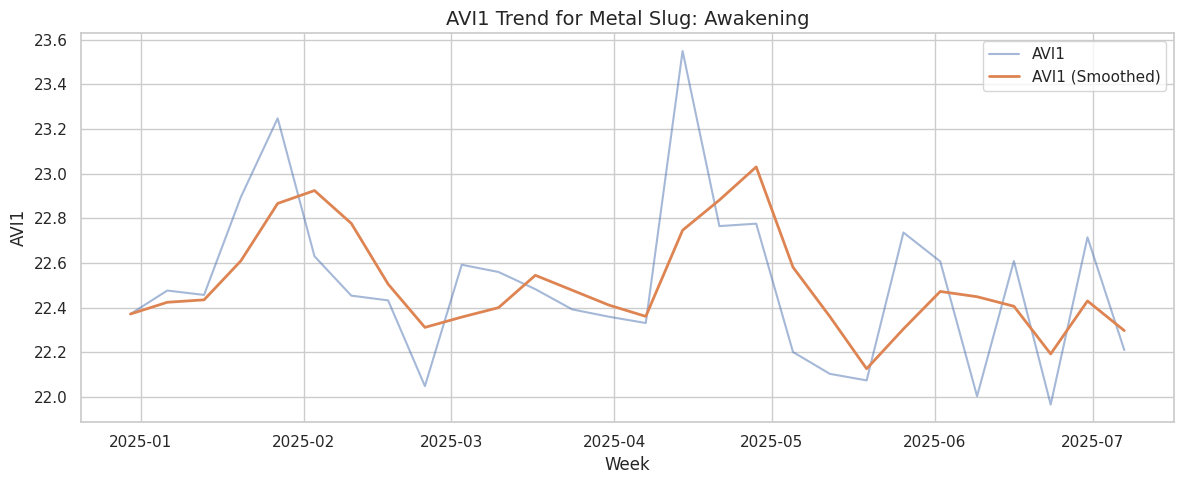

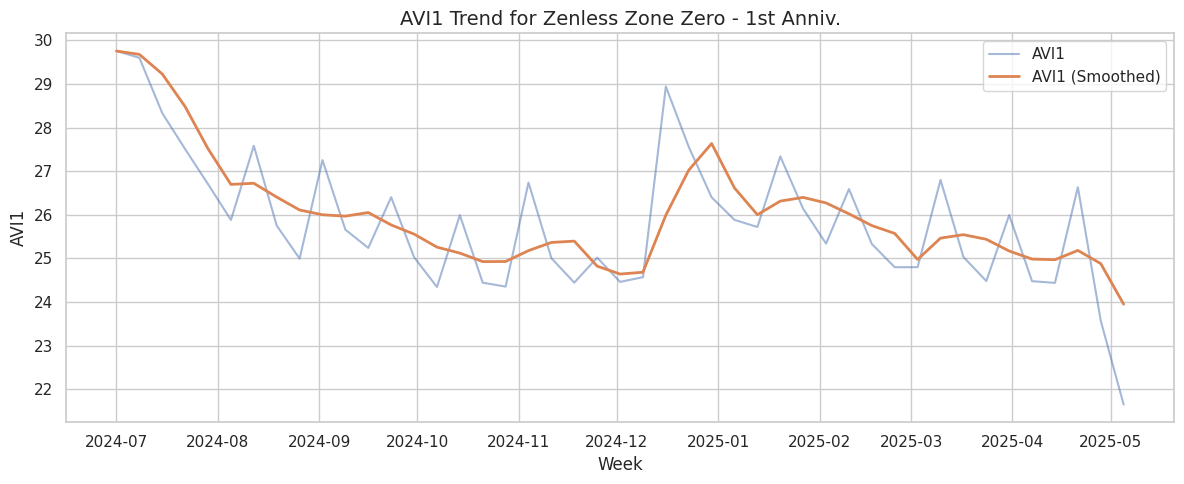

In [ ]:
#Visualization
# style
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# access data
games = weekly_md_1['Name'].unique()

# Draw for every game
for game in games:
    subset = weekly_md_1[weekly_md_1['Name'] == game]

    plt.figure(figsize=(12, 5))
    plt.plot(subset['Week'], subset['AVI1'], label='AVI1', alpha=0.5)
    plt.plot(subset['Week'], subset['AVI1_smooth'], label='AVI1 (Smoothed)', linewidth=2)

    plt.title(f'AVI1 Trend for {game}', fontsize=14)
    plt.xlabel('Week')
    plt.ylabel('AVI1')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

###2.4 Conclustion

The result indicates that AVI1,which introduced a small positive value instead of 1, dosen't make a big difference to the AVI value under condition that the AVI was processed with weekly aggregation.Thus, we choose WAVI_smooth as the Final AVI indicator.

In [ ]:
#see
weekly_md.head()

,Name,Week,DAU,Revenue,WAVI,WAVI_smooth
0,Dawn of kingdoms,2022-03-28,97281.916667,7393367.08,27.301462,27.301462
1,Dawn of kingdoms,2022-04-04,71847.714286,8464934.44,27.133747,27.217605
2,Dawn of kingdoms,2022-04-11,56306.142857,6696899.02,26.655714,27.030308
3,Dawn of kingdoms,2022-04-18,49249.642857,5084670.74,26.246398,26.678620
4,Dawn of kingdoms,2022-04-25,48414.714286,4219808.02,26.042859,26.314991


In [ ]:
df_AVI = weekly_md[['Name', 'Week', 'WAVI_smooth']].rename(columns={'WAVI_smooth': 'AVI'})
df_AVI.head()

,Name,Week,AVI
0,Dawn of kingdoms,2022-03-28,27.301462
1,Dawn of kingdoms,2022-04-04,27.217605
2,Dawn of kingdoms,2022-04-11,27.030308
3,Dawn of kingdoms,2022-04-18,26.678620
4,Dawn of kingdoms,2022-04-25,26.314991


In [ ]:
df_AVI.to_csv("Final_AVI_Data.csv", index=False)